<img src="./images/data-summer-conf.jpg"/>

<h1 align="center" font-size="100">
    Automated Feature Engineering with 
    <img src="./images/featuretools-logo.png" width="30%"/>
</h1>
<h4 align="right">
    By Fred Navruzov <br/>
    (2017-07-21, Odessa, Ukraine)<br/>
</h4>

<a id="table-of-contents"/>

---
# Table of Contents

1. **[About this Workshop](#about-workshop)**
 
2. **[About the Competition](#about-competition)**  

3. **[Data Load & Cleaning](#data-load)**  

4. **[Featuretools intuition](#featuretools-intuition)**   
  4.1 [Data preparation](#data-preparation)  
  4.2 [Entities and EntitySet](#entityset-creation)  
  4.3 [Relationships](#relationship-creation)  
  4.4 [Feature primitives](#feature-primitives)  
  4.5 [Deep feature synthesis](#dfs)  
  4.6 [Advanced usage](#ft-advanced)  
  4.7 [Put it All Together](#all-together)
5. **[Model preparation & Actual computations](#computations)**  
6. **[Special Thanks](#special-thanks)**  
7. **[Useful Links](#useful-links)**  

<a id='about-workshop'/>

---
# About this Workshop
---

Within this workshop, we will walk through applying automated feature engineering to the [Home Credit Default Risk dataset](https://www.kaggle.com/c/home-credit-default-risk) using the featuretools library. [Featuretools](https://docs.featuretools.com/) is an open-source Python package for automatically creating new features from multiple tables of structured, related data. It is ideal tool for problems such as the Home Credit Default Risk competition where there are several related tables that need to be combined into a single dataframe for training (and one for testing). 

## Feature Engineering

The objective of [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is to create new features (alos called explantory variables or predictors) to represent as much information from an entire dataset in one table.  Typically, this process is **"hand-made"** using pandas operations such as `groupby`, `agg`, or `merge` and can be very tedious. 
<br/>Moreover, manual feature engineering is limited both by human time constraints and imagination: we simply cannot conceive of every possible feature that will be useful. 

The importance of creating the proper features cannot be overstated because a machine learning model can only learn from the data we give to it. Extracting as much information as possible from the available datasets is crucial to creating an effective solution.

[Automated feature engineering](https://towardsdatascience.com/automated-feature-engineering-in-python-99baf11cc219) aims to help the data scientist with the problem of feature creation by automatically building hundreds or thousands of new features from a dataset. **Featuretools - the only open-sourced library for automated feature engineering at the moment** - will not replace the data scientist's value, but will allow instead to focus on more valuable parts of the machine learning pipeline, such as delivering robust models into production. 

Here we will touch on the concepts of automated feature engineering with featuretools and show how to implement it for the Home Credit Default Risk competition. 

We will stick to the basics so we can get the ideas down and then build upon this foundation in later work when we customize featuretools. We will work with **a subset of the data because this is a computationally intensive job**

[Back to the Table of Contents](#table-of-contents)

<a id="about-competition"/>

---
# About the Competition
---

## Task

The Home Credit Default Risk competition is a **supervised ML task**. The objective is to use historical financial and behavioral data to predict whether or not an applicant will have difficulties repaying a loan:

* __Supervised__: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features
* __Classification__: The label is binary:
    - 0 (will repay loan on time)
    - 1 (will have difficulties repaying loan)

## Dataset

The data is provided by [Home Credit](http://www.homecredit.net/about-us.aspx), a service dedicated to provided lines of credit (loans) to the unbanked population. 

There are 7 different data files:

* __application_train/application_test__: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the `SK_ID_CURR`. The training application data comes with the `TARGET` with indicating 0: the loan was repaid and 1: the loan was not repaid. 


* __bureau__: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau and is identified by the `SK_ID_BUREAU`, Each loan in the application data can have multiple previous credits.


* __bureau_balance__: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length. 


* __previous_application__: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature `SK_ID_PREV`. 


* __POS_CASH_BALANCE__: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.


* __credit_card_balance__: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.


* __installments_payment__: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. 

The diagram below shows the relationships among the tables. This will be very useful when we need to define relationships in featuretools. 

<h1 align="center"> Here's what data relationships look like: </h1>

---

<img src="./images/home_credit-tables.png"/>

[Back to the Table of Contents](#table-of-contents)

<a id='data-load' />

---
# Data Load & Cleaning

In [1]:
# main library imports
import pandas as pd
import numpy as np

# ML part
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# system
import gc
gc.enable()

import time
from os.path import join as pjoin
from os import cpu_count

import warnings
warnings.filterwarnings('ignore')

# featuretools and supportives
import featuretools as ft
import competition_utils as cu

# plotting and display
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 250
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 200
pd.options.display.float_format = '{:.4f}'.format

%matplotlib inline

In [2]:
# define data filepaths
data_dir = 'data'

filepaths = {
    'data_desc': pjoin(data_dir, 'HomeCredit_columns_description.csv'),
    'app_train': pjoin(data_dir, 'application_train.zip'),
    'app_test': pjoin(data_dir, 'application_test.zip'),
    'bureau': pjoin(data_dir, 'bureau.zip'),
    'bureau_bl': pjoin(data_dir, 'bureau_balance.zip'),
    'credit_bl': pjoin(data_dir, 'credit_card_balance.zip'),
    'install_pays': pjoin(data_dir, 'installments_payments.zip'),
    'pc_balance': pjoin(data_dir, 'POS_CASH_balance.zip'),
    'app_prev': pjoin(data_dir, 'previous_application.zip'),
}

In [3]:
# load data description and see samples
df_data_desc = pd.read_csv(filepaths['data_desc'], encoding='latin1')
df_data_desc = df_data_desc[df_data_desc.columns[1:]].fillna('')
df_data_desc.head(10)

,Table,Row,Description,Special
0,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,
1,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",
2,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,
3,application_{train|test}.csv,CODE_GENDER,Gender of the client,
4,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,
5,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,
6,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,
7,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,
8,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,
9,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,


### Disclaimer!

For this particular example **only 5,000 IDs from applications test/train are used in computations**. <br/>
Other tables are also limited to rows, having only those correspondent IDs in relationships

### APPLICATION datasets

In [4]:
df_train = pd.read_csv(filepaths['app_train'], compression='zip')
df_test = pd.read_csv(filepaths['app_test'], compression='zip')

# remove non-overlapped categorical values
df_train, df_test = cu.clean_non_overlapped_values(
    df_train, 
    df_test, 
    verbose=True
)

# concatenate dataframes together, check shapes
print(f'\ntrain shape:  {df_train.shape}\ntest shape:   {df_test.shape}')
df_joint = pd.concat([df_train, df_test])

# optimize dtypes
df_joint = cu.reduce_mem_usage(df_joint, skip_cols_pattern='SK_ID_')

del df_train, df_test
gc.collect()

# specify target column name
target_col = 'TARGET'

# define train/test indexes
idx_train = ~df_joint[target_col].isnull()
idx_test = ~idx_train

# define train/test ids
ids_train = df_joint[~df_joint[target_col].isnull()].SK_ID_CURR.tolist()
ids_test = df_joint[df_joint[target_col].isnull()].SK_ID_CURR.tolist()

print(f'\ntrain rows: {idx_train.sum()}\ntest rows:  {idx_test.sum()}')

# substitute NaNs, defined by organizers, align categorical values etc.

# deal with missing values and outliers
df_joint = cu.replace_day_outliers(df_joint)
df_joint = cu.replace_missing_app(df_joint)

# replace "true" NaNs with np.nan
df_joint = df_joint.replace(['XNA', 'XAP'], np.nan)

# check shape
print(f'data shape: {df_joint.shape}')

# see data sample
df_joint.head()

feature NAME_INCOME_TYPE has different values: {'Businessman', 'Unemployed'}
feature ORGANIZATION_TYPE has different values: {'Trade: type 5'}
{'NAME_INCOME_TYPE': {'Businessman', 'Unemployed'}, 'ORGANIZATION_TYPE': {'Trade: type 5'}}

train shape:  (5000, 122)
test shape:   (5000, 121)
Memory usage of dataframe is 9.38 MB
don't optimize index SK_ID_CURR
Memory usage after optimization is: 2.07 MB
Decreased by 78.0%

train rows: 5000
test rows:  5000
data shape: (10000, 122)


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,...,FLOORSMIN_MODE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,24700.5000,406597.5000,351000.0000,202500.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0247,0.0250,0.0252,0.0369,0.0369,0.0383,0,1.0000,M,0.0143,0.0144,0.0144,-9461,-637.0000,-2120,-1134.0000,-3648.0000,2.0000,2.0000,0.0000,0.0000,0.0000,No,0.0690,0.0690,0.0690,0.0830,0.2629,0.1394,1,0,0,0,0,0,0,0,0,0,0,...,0.1250,reg oper account,10,block of flats,0.0369,0.0375,0.0377,0,0,0.0202,0.0205,0.0220,0.0190,0.0193,0.0198,Cash loans,Secondary / secondary special,Single / not married,House / apartment,Working,Unaccompanied,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,2.0000,Laborers,Business Entity Type 3,nan,0.0188,2,2,0,0,0,0,100002,1.0000,0.0149,"Stone, brick",WEDNESDAY,0.9722,0.9722,0.9722,0.6191,0.6245,0.6343
1,35698.5000,1293502.5000,1129500.0000,270000.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0959,0.0968,0.0924,0.0529,0.0529,0.0538,0,2.0000,F,0.0605,0.0608,0.0497,-16765,-1188.0000,-291,-828.0000,-1186.0000,0.0000,0.0000,0.0800,0.0800,0.0806,No,0.0345,0.0345,0.0345,0.3113,0.6221,nan,1,0,0,0,0,0,0,0,0,0,0,...,0.3333,reg oper account,11,block of flats,0.0130,0.0132,0.0128,0,0,0.0773,0.0787,0.0790,0.0549,0.0558,0.0554,Cash loans,Higher education,Married,House / apartment,State servant,Family,0.0039,0.0039,0.0000,0.0098,0.0100,0.0000,1.0000,1.0000,Core staff,School,nan,0.0035,1,1,0,0,0,0,100003,0.0000,0.0714,Block,MONDAY,0.9849,0.9849,0.9849,0.7959,0.7988,0.8042
2,6750.0000,135000.0000,135000.0000,67500.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000,0.0000,nan,0,1.0000,M,0.0000,0.0000,nan,-19046,-225.0000,-2531,-815.0000,-4260.0000,0.0000,0.0000,0.0000,0.0000,nan,NaN,0.0000,0.0000,nan,nan,0.5562,0.7295,1,0,0,0,0,0,0,0,0,0,0,...,nan,NaN,9,NaN,0.0000,0.0000,nan,0,0,0.0000,0.0000,nan,0.0000,0.0000,nan,Revolving loans,Secondary / secondary special,Single / not married,House / apartment,Working,Unaccompanied,0.0000,0.0000,nan,0.0000,0.0000,nan,0.0000,0.0000,Laborers,Government,26.0000,0.0100,2,2,0,0,0,0,100004,0.0000,nan,NaN,MONDAY,0.0000,0.0000,nan,0.0000,0.0000,nan
3,29686.5000,312682.5000,297000.0000,135000.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000

### BUREAU table

In [5]:

df_bureau = pd.read_csv(filepaths['bureau'])
# optimize dtypes
df_bureau = cu.reduce_mem_usage(df_bureau, skip_cols_pattern='SK_ID_')

# deal with missing values and outliers
df_bureau = cu.replace_day_outliers(df_bureau)

# replace "true" NaNs with np.nan
df_bureau = df_bureau.replace(['XNA', 'XAP'], np.nan)

# check shape
print(f'data shape: {df_bureau.shape}')

# see data sample
df_bureau.head()

Memory usage of dataframe is 6.38 MB
don't optimize index SK_ID_CURR
don't optimize index SK_ID_BUREAU
Memory usage after optimization is: 2.54 MB
Decreased by 60.3%
data shape: (49227, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,101060,5715559,Closed,currency 1,-1087,0,-874.0000,-902.0000,nan,0,74242.7969,0.0000,nan,0.0000,Consumer credit,-711,nan
1,101060,5715560,Active,currency 1,-709,0,783.0000,nan,nan,0,395940.6875,270998.8125,nan,0.0000,Consumer credit,-7,nan
2,101060,5715561,Active,currency 1,-886,0,479.0000,nan,nan,0,270000.0000,137875.5000,0.0000,0.0000,Credit card,-26,nan
3,101060,5715564,Closed,currency 1,-2632,0,-2478.0000,-2540.0000,0.0000,0,76392.0000,0.0000,0.0000,0.0000,Consumer credit,-2539,nan
4,104261,5715630,Active,currency 1,-587,0,872.0000,nan,nan,0,450000.0000,317925.0000,0.0000,0.0000,Consumer credit,-6,14301.0000


In [6]:
# bureau balance table
df_bureau_bl = pd.read_csv(filepaths['bureau_bl'], compression='zip')

# deal with missing values and outliers
df_bureau_bl = cu.replace_day_outliers(df_bureau_bl)

# replace "true" NaNs with np.nan
df_bureau_bl = df_bureau_bl.replace(['XNA', 'XAP'], np.nan)

# optimize dtypes
df_bureau_bl = cu.reduce_mem_usage(df_bureau_bl, skip_cols_pattern='SK_ID_')

# check shape
print(f'data shape: {df_bureau_bl.shape}')

# see data sample
df_bureau_bl.head()

Memory usage of dataframe is 27.63 MB
don't optimize index SK_ID_BUREAU
Memory usage after optimization is: 11.51 MB
Decreased by 58.3%
data shape: (1207059, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5718724,0,0
1,5718724,-1,0
2,5718724,-2,0
3,5718724,-3,0
4,5718725,0,C


### previous application table

In [7]:
# previous application table
df_app_prev = pd.read_csv(filepaths['app_prev'])

# deal with missing values and outliers
df_app_prev = cu.replace_day_outliers(df_app_prev)

# replace "true" NaNs with np.nan
df_app_prev = df_app_prev.replace(['XNA', 'XAP'], np.nan)

# check for labels in test, not present in train and vice versa (XOR)
df_app_prev = cu.clean_non_overlapped_values(
    df_app_prev[df_app_prev.SK_ID_CURR.isin(ids_train)], 
    df_app_prev[df_app_prev.SK_ID_CURR.isin(ids_test)],
    concat=True,
)

# optimize dtypes
df_app_prev = cu.reduce_mem_usage(df_app_prev, skip_cols_pattern='SK_ID_')

# check shape
print(f'data shape: {df_app_prev.shape}')

# see data sample
df_app_prev.head()

feature NAME_CASH_LOAN_PURPOSE has different values: {'Buying a garage', 'Hobby'}
feature NAME_GOODS_CATEGORY has different values: {'Insurance', 'Weapon'}
{'NAME_CASH_LOAN_PURPOSE': {'Buying a garage', 'Hobby'}, 'NAME_GOODS_CATEGORY': {'Insurance', 'Weapon'}}
Memory usage of dataframe is 14.23 MB
don't optimize index SK_ID_PREV
don't optimize index SK_ID_CURR
Memory usage after optimization is: 4.13 MB
Decreased by 71.0%
data shape: (49100, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1,1168659,101529,Cash loans,nan,0.0000,0.0000,nan,nan,TUESDAY,11,Y,1,nan,nan,nan,NaN,Refused,-115,NaN,HC,NaN,Repeater,NaN,NaN,NaN,Credit and cash offices,-1,NaN,nan,NaN,Cash,nan,nan,nan,nan,nan,nan
2,2686051,101529,Cash loans,nan,0.0000,0.0000,nan,nan,TUESDAY,9,Y,1,nan,nan,nan,NaN,Canceled,-164,NaN,NaN,NaN,Repeater,NaN,NaN,NaN,Credit and cash offices,-1,NaN,nan,NaN,Cash,nan,nan,nan,nan,nan,nan
3,1891648,100373,Consumer loans,10872.9902,115695.0000,115119.0000,11569.5000,115695.0000,SATURDAY,22,Y,1,0.0995,nan,nan,NaN,Approved,-1053,Cash through the bank,NaN,Unaccompanied,New,Medicine,POS,NaN,Stone,25,Industry,12.0000,low_normal,POS household with interest,nan,-1013.0000,-683.0000,-713.0000,-709.0000,0.0000
4,2283315,102649,Consumer loans,12540.5996,60423.2539,63414.0000,1.7550,60423.2539,SUNDAY,15,Y,1,0.0000,nan,nan,NaN,Approved,-1452,Cash through the bank,NaN,Unaccompanied,New,Construction Materials,POS,NaN,Stone,463,Construction,6.0000,high,POS industry with interest,nan,-1421.0000,-1271.0000,-1271.0000,-1262.0000,0.0000
5,1348316,104826,Revolving loans,22500.0000,450000.0000,450000.0000,nan,450000.0000,MONDAY,14,Y,1,nan,nan,nan,NaN,Refused,-183,NaN,HC,Unaccompanied,Repeater,NaN,Cards,x-sell,Credit and cash offices,-1,NaN,0.0000,NaN,Card X-Sell,nan,nan,nan,nan,nan,nan


### Pos Cash Balance table

In [8]:
# Pos Cash Balance Table
df_pc_balance = pd.read_csv(filepaths['pc_balance'])

# deal with missing values and outliers
df_pc_balance = cu.replace_day_outliers(df_pc_balance)

# replace "true" NaNs with np.nan
df_pc_balance = df_pc_balance.replace(['XNA', 'XAP'], np.nan)

# optimize dtypes
df_pc_balance = cu.reduce_mem_usage(df_pc_balance, skip_cols_pattern='SK_ID_')

# check shape
print(f'data shape: {df_pc_balance.shape}')

# see data sample
df_pc_balance.head()

Memory usage of dataframe is 17.56 MB
don't optimize index SK_ID_PREV
don't optimize index SK_ID_CURR
Memory usage after optimization is: 7.13 MB
Decreased by 59.4%
data shape: (287697, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1463929,108990,-41,12.0000,12.0000,Active,0,0
1,2547775,100676,-41,24.0000,12.0000,Active,0,0
2,1425540,101741,-33,24.0000,8.0000,Active,0,0
3,1335460,103808,-34,12.0000,3.0000,Active,0,0
4,2243016,105075,-29,10.0000,2.0000,Active,0,0


### Credit Card Balance table

In [9]:
# Credit Card Balance Table
df_credit_bl = pd.read_csv(filepaths['credit_bl'])

# deal with missing values and outliers
df_credit_bl = cu.replace_day_outliers(df_credit_bl)

# replace "true" NaNs with np.nan
df_credit_bl = df_credit_bl.replace(['XNA', 'XAP'], np.nan)

# check for labels in test, not present in train and vice versa (XOR)
df_credit_bl = cu.clean_non_overlapped_values(
    df_credit_bl[df_credit_bl.SK_ID_CURR.isin(ids_train)], 
    df_credit_bl[df_credit_bl.SK_ID_CURR.isin(ids_test)],
    concat=True,
)

# optimize dtypes
df_credit_bl = cu.reduce_mem_usage(df_credit_bl, skip_cols_pattern='SK_ID_')

# check shape
print(f'data shape: {df_credit_bl.shape}')

# see data sample
df_credit_bl.head()

feature NAME_CONTRACT_STATUS has different values: {'Refused'}
{'NAME_CONTRACT_STATUS': {'Refused'}}
Memory usage of dataframe is 20.76 MB
don't optimize index SK_ID_PREV
don't optimize index SK_ID_CURR
Memory usage after optimization is: 9.30 MB
Decreased by 55.2%
data shape: (113392, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
1,2021411,105755,-5,464452.4688,450000,135000.0000,279112.5000,137700.0000,6412.5000,8920.0000,9000.0000,9000.0000,448552.1250,456379.4688,456379.4688,5.0000,7,1.0000,1.0000,25.0000,Active,0,0
4,1940476,104946,-1,0.0000,45000,0.0000,0.0000,0.0000,0.0000,0.0000,132.8850,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,54.0000,Active,0,0
5,2408643,104761,-4,0.0000,225000,nan,0.0000,nan,nan,0.0000,nan,0.0000,0.0000,0.0000,0.0000,nan,0,nan,nan,0.0000,Active,0,0
8,2306532,100796,-4,0.0000,292500,0.0000,0.0000,0.0000,0.0000,0.0000,509.1750,509.1750,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,41.0000,Active,0,0
9,1128014,102143,-3,0.0000,135000,0.0000,20419.7402,0.0000,20419.7402,0.0000,31156.8301,31156.8301,0.0000,0.0000,0.0000,0.0000,5,0.0000,5.0000,4.0000,Active,0,0


### Install Payments table

In [10]:
# Install Payments Table
df_install_pays = pd.read_csv(filepaths['install_pays'])

# deal with missing values and outliers
df_install_pays = cu.replace_day_outliers(df_install_pays)

# replace "true" NaNs with np.nan
df_install_pays = df_install_pays.replace(['XNA', 'XAP'], np.nan)

# check for labels in test, not present in train and vice versa (XOR)
df_install_pays = cu.clean_non_overlapped_values(
    df_install_pays[df_install_pays.SK_ID_CURR.isin(ids_train)], 
    df_install_pays[df_install_pays.SK_ID_CURR.isin(ids_test)],
    concat=True,
)

# optimize dtypes
df_install_pays = cu.reduce_mem_usage(df_install_pays, skip_cols_pattern='SK_ID_')

# check shape
print(f'data shape: {df_install_pays.shape}')

# see data sample
df_install_pays.head()

{}
Memory usage of dataframe is 26.96 MB
don't optimize index SK_ID_PREV
don't optimize index SK_ID_CURR
Memory usage after optimization is: 14.98 MB
Decreased by 44.4%
data shape: (392693, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
1,1594684,100193,0.0000,56,-1153.0000,-1153.0000,301.8600,301.8600
3,2154310,105713,1.0000,8,-198.0000,-207.0000,21954.5996,21954.5996
5,2379431,102345,0.0000,84,-1389.0000,-1396.0000,8100.0000,8100.0000
11,2776579,101266,1.0000,5,-1438.0000,-1441.0000,14780.4297,14780.4297
15,2105136,100605,1.0000,9,-65.0000,-80.0000,7679.4302,7679.4302


<a id='featuretools-intuition'/>

[Back to the Table of Contents](#table-of-contents)

---
# Featuretools Intuition
---

<a id='intro'/>

[Featuretools](https://docs.featuretools.com/#minute-quick-start) is an open-source Python library for automatically creating features out of a set of related tables using a technique called [deep feature synthesis](http://www.jmaxkanter.com/static/papers/DSAA_DSM_2015.pdf). Automated feature engineering, like many topics in machine learning, is a complex subject built upon a foundation of simpler ideas. By going through these ideas one at a time, we can build up our understanding of how featuretools which will later allow for us to get the most out of it.

There are a few concepts that we will cover along the way:

* [Entities and EntitySets](https://docs.featuretools.com/loading_data/using_entitysets.html)
* [Relationships between tables](https://docs.featuretools.com/loading_data/using_entitysets.html#adding-a-relationship)
* [Feature primitives](https://docs.featuretools.com/automated_feature_engineering/primitives.html): aggregations and transformations
* [Deep feature synthesis](https://docs.featuretools.com/automated_feature_engineering/afe.html)

<a id='data-preparation'/>

### Data preparation
let's create entity set and fill it with entities
however, some work still needs to be done BEFORE actual creation:
- define specific data types (to make it easier for FeatureTools to operate on data)
- define / create unique indexes among all involved tables
- define / create time indexes for tables with temporal structure

#### Datetype definition

In [11]:
# here's an example
app_types = {}

# Iterate through the columns and record the Boolean columns
for col in df_joint.drop('TARGET', axis=1):
    # If column is a number with only two values, encode it as a Boolean
    if (df_joint[col].dtype != 'object') and (df_joint[col].nunique() <= 2):
        app_types[col] = ft.variable_types.Boolean

print('Number of boolean variables: ', len(app_types))

# encode ordinal:
df_joint.loc[:, 'NAME_EDUCATION_TYPE'] = df_joint.loc[:, 'NAME_EDUCATION_TYPE'].map({
    'Lower secondary': 0,
    'Secondary / secondary special': 1,
    'Incomplete higher': 2,
    'Higher education': 3,
    'Academic degree': 4,
}).astype(np.uint8)

app_types['NAME_EDUCATION_TYPE'] = ft.variable_types.Ordinal
app_types['REGION_RATING_CLIENT'] = ft.variable_types.Ordinal
app_types['REGION_RATING_CLIENT_W_CITY'] = ft.variable_types.Ordinal

# Record boolean variables in the previous data
previous_types= {
    'NFLAG_LAST_APPL_IN_DAY': ft.variable_types.Boolean,
    'NFLAG_INSURED_ON_APPROVAL': ft.variable_types.Boolean
}

Number of boolean variables:  37


Time can be a crucial factor in many datasets because behaviors change over time and therefore we want to make features to reflect this. For example, a client might be taking out larger and larger loans over time which could be an indicator that they are about to default or they could have a run of missed payments but then get back on track.

There are no explicit datetimes in the data, but there are relative time offsets. All the time offset are measured from the current application at Home Credit and are measured in months or days. For example, in `bureau`, the `DAYS_CREDIT` column represents "How many days before current application did client apply for Credit Bureau credit". (Credit Bureau refers to any other credit organization besides Home Credit). Although we do not know the actual application date, if we assume a starting application date that is the same for all clients, then we can convert the `MONTHS_BALANCE` into a datetime. This can then be treated as a relative time that we can use to find trends or identify the most recent value of a variable. 

#### Creation of time indexes

In [12]:
# Time index

# Establish a starting date for all applications at Home Credit
start_date = pd.Timestamp("2018-01-01")

# Convert to timedelta in days
for col in ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']:
    df_bureau[col] = pd.to_timedelta(df_bureau[col], 'D')
    
# Create the date columns
df_bureau['bureau_credit_application_date'] = start_date + df_bureau['DAYS_CREDIT']
df_bureau['bureau_credit_end_date'] = start_date + df_bureau['DAYS_CREDIT_ENDDATE']
df_bureau['bureau_credit_close_date'] = start_date + df_bureau['DAYS_ENDDATE_FACT']
df_bureau['bureau_credit_update_date'] = start_date + df_bureau['DAYS_CREDIT_UPDATE']


# Drop the time offset columns
df_bureau = df_bureau.drop(
    columns=['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']
)

# Convert to timedelta
df_bureau_bl['MONTHS_BALANCE'] = pd.to_timedelta(df_bureau_bl['MONTHS_BALANCE'], 'M')

# Make a date column
df_bureau_bl['bureau_balance_date'] = start_date + df_bureau_bl['MONTHS_BALANCE']
df_bureau_bl = df_bureau_bl.drop(columns = ['MONTHS_BALANCE'])

# Convert to timedeltas in days
for col in [
    'DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 
    'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION'
]:
    df_app_prev[col] = pd.to_timedelta(df_app_prev[col], 'D')
    
# Make date columns
df_app_prev['previous_decision_date'] = start_date + df_app_prev['DAYS_DECISION']
df_app_prev['previous_drawing_date'] = start_date + df_app_prev['DAYS_FIRST_DRAWING']
df_app_prev['previous_first_due_date'] = start_date + df_app_prev['DAYS_FIRST_DUE']
df_app_prev['previous_last_duefirst_date'] = start_date + \
df_app_prev['DAYS_LAST_DUE_1ST_VERSION']

df_app_prev['previous_last_due_date'] = start_date + df_app_prev['DAYS_LAST_DUE']
df_app_prev['previous_termination_date'] = start_date + df_app_prev['DAYS_TERMINATION']

# Drop the time offset columns
df_app_prev = df_app_prev.drop(
    columns=['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 
             'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']
)

# Convert to timedelta objects
df_pc_balance['MONTHS_BALANCE'] = pd.to_timedelta(df_pc_balance['MONTHS_BALANCE'], 'M')

# Make a date column
df_pc_balance['cash_balance_date'] = start_date + df_pc_balance['MONTHS_BALANCE']
df_pc_balance = df_pc_balance.drop(columns=['MONTHS_BALANCE'])

# Convert to timedelta objects
df_credit_bl['MONTHS_BALANCE'] = pd.to_timedelta(df_credit_bl['MONTHS_BALANCE'], 'M')

# Make a date column
df_credit_bl['credit_balance_date'] = start_date + df_credit_bl['MONTHS_BALANCE']
df_credit_bl = df_credit_bl.drop(columns=['MONTHS_BALANCE'])

# Convert to time delta object
df_install_pays['DAYS_INSTALMENT'] = pd.to_timedelta(
    df_install_pays['DAYS_INSTALMENT'], 'D')
df_install_pays['DAYS_ENTRY_PAYMENT'] = pd.to_timedelta(
    df_install_pays['DAYS_ENTRY_PAYMENT'], 'D')

# Create time column and drop
df_install_pays['installments_due_date'] = start_date + df_install_pays['DAYS_INSTALMENT']
df_install_pays = df_install_pays.drop(columns = ['DAYS_INSTALMENT'])

df_install_pays['installments_paid_date'] = start_date + df_install_pays['DAYS_ENTRY_PAYMENT']
df_install_pays = df_install_pays.drop(columns=['DAYS_ENTRY_PAYMENT'])

[Back to the Table of Contents](#table-of-contents)

<a id='entityset-creation'/>

### Entities and Entitysets

An entity is simply a table or in Pandas, a `dataframe`. The observations are in the rows and the features in the columns. An entity in featuretools must have a unique index where none of the elements are duplicated.  Currently, only `app`, `bureau`, and `previous` have unique indices (`SK_ID_CURR`, `SK_ID_BUREAU`, and `SK_ID_PREV` respectively). For the other dataframes, we must pass in `make_index = True` and then specify the name of the index. Entities can also have time indices where each entry is identified by a unique time. (There are not datetimes in any of the data, but there are relative times, given in months or days, that we could consider treating as time variables).

An [EntitySet](https://docs.featuretools.com/loading_data/using_entitysets.html) is a **collection of tables and the relationships between them**. This can be thought of a data structute with its own methods and attributes. Using an EntitySet allows us to group together multiple tables and manipulate them much quicker than individual tables. 

In [13]:
# Make an entityset
es = ft.EntitySet(id='clients')

main_entity_id = 'app_train'
df = df_joint[idx_train].copy()

# Entities with a unique index
es = es.entity_from_dataframe(
    entity_id=main_entity_id, 
    dataframe=df, # dataframe object
    index='SK_ID_CURR', # unique index
    variable_types=app_types # defined specific data types (if needed)
)

es = es.entity_from_dataframe(
    entity_id = 'bureau', 
    dataframe = df_bureau, 
    index = 'SK_ID_BUREAU',
    time_index='bureau_credit_application_date' # recently created time index
)

es = es.entity_from_dataframe(
    entity_id='previous', 
    dataframe=df_app_prev,
    index='SK_ID_PREV', 
    time_index='previous_decision_date',
    variable_types=previous_types
)

# Entities that do not have a unique index
es = es.entity_from_dataframe(
    entity_id='bureau_balance', 
    dataframe=df_bureau_bl, 
    make_index=True, # need to create unique index from scratch
    index='bb_index', # name it
    time_index='bureau_balance_date'
)

es = es.entity_from_dataframe(
    entity_id='cash', 
    dataframe=df_pc_balance, 
    make_index=True, # the similar index is created here
    index='cash_index',
    time_index='cash_balance_date'
)

es = es.entity_from_dataframe(
    entity_id='installments', 
    dataframe=df_install_pays,
    make_index=True, # and here
    index='installments_index',
    time_index='installments_paid_date'
)

es = es.entity_from_dataframe(
    entity_id='credit', 
    dataframe=df_credit_bl,
    make_index=True, # here too
    index='credit_index',
    time_index='credit_balance_date'
)

# check obtained entityset - see, no relationships created yet
es

Entityset: clients
  Entities:
    app_train [Rows: 5000, Columns: 122]
    bureau [Rows: 49227, Columns: 17]
    previous [Rows: 49100, Columns: 37]
    bureau_balance [Rows: 1207059, Columns: 4]
    cash [Rows: 287697, Columns: 9]
    installments [Rows: 392693, Columns: 9]
    credit [Rows: 113392, Columns: 24]
  Relationships:
    No relationships

In [14]:
# check particular entity, what's it look like
es['installments']

Entity: installments
  Variables:
    installments_index (dtype: index)
    SK_ID_PREV (dtype: numeric)
    SK_ID_CURR (dtype: numeric)
    NUM_INSTALMENT_VERSION (dtype: numeric)
    NUM_INSTALMENT_NUMBER (dtype: numeric)
    AMT_INSTALMENT (dtype: numeric)
    AMT_PAYMENT (dtype: numeric)
    installments_due_date (dtype: datetime)
    installments_paid_date (dtype: datetime_time_index)
  Shape:
    (Rows: 392693, Columns: 9)

[Back to the Table of Contents](#table-of-contents)

<a id='relationship-creation'/>

### Relationships

Relationships are a fundamental concept not only in featuretools, but in any relational database. The best way to think of a one-to-many relationship is with the analogy of **parent-to-child**. A parent is a single individual, but can have mutliple children. The children can then have multiple children of their own. In a _parent table_, each individual has a single row. Each individual in the parent table can have multiple rows in the _child table_. 

As an example, the `app` dataframe has one row for each client  (`SK_ID_CURR`) while the `bureau` dataframe has multiple previous loans (`SK_ID_PREV`) for each parent (`SK_ID_CURR`). Therefore, the `bureau` dataframe is the child of the `app` dataframe. The `bureau` dataframe in turn is the parent of `bureau_balance` because each loan has one row in `bureau` but multiple monthly records in `bureau_balance`. 

In [15]:
# relationships -------------------------------------------

# Relationship between app and bureau
r_app_bureau = ft.Relationship(
    es[main_entity_id]['SK_ID_CURR'], 
    es['bureau']['SK_ID_CURR']
)

# Relationship between bureau and bureau balance
r_bureau_balance = ft.Relationship(
    es['bureau']['SK_ID_BUREAU'], 
    es['bureau_balance']['SK_ID_BUREAU']
)

# Relationship between current dataset and previous apps
r_app_previous = ft.Relationship(
    es[main_entity_id]['SK_ID_CURR'], 
    es['previous']['SK_ID_CURR']
)

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = ft.Relationship(
    es['previous']['SK_ID_PREV'], 
    es['cash']['SK_ID_PREV']
)
r_previous_installments = ft.Relationship(
    es['previous']['SK_ID_PREV'], 
    es['installments']['SK_ID_PREV']
)
r_previous_credit = ft.Relationship(
    es['previous']['SK_ID_PREV'], 
    es['credit']['SK_ID_PREV']
)

# Add in the defined relationships
es = es.add_relationships(
    [
        r_app_bureau,  
        r_bureau_balance, 
        r_app_previous, 
        r_previous_cash, 
        r_previous_installments, 
        r_previous_credit
    ]
)

# let's see updated EntitySet
es

Entityset: clients
  Entities:
    app_train [Rows: 5000, Columns: 122]
    bureau [Rows: 49227, Columns: 17]
    previous [Rows: 49100, Columns: 37]
    bureau_balance [Rows: 1207059, Columns: 4]
    cash [Rows: 287697, Columns: 9]
    installments [Rows: 392693, Columns: 9]
    credit [Rows: 113392, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app_train.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app_train.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

Slightly advanced note: we need **to be careful** to not create a [diamond graph](https://en.wikipedia.org/wiki/Diamond_graph) where there are multiple paths from a parent to a child. If we directly link `app` and `cash` via `SK_ID_CURR`; `previous` and `cash` via `SK_ID_PREV`; and `app` and `previous` via `SK_ID_CURR`, then we have created two paths from `app` to `cash`. This results in ambiguity, so the approach we have to take instead is to link `app` to `cash` through `previous`. We establish a relationship between `previous` (the parent) and `cash` (the child) using `SK_ID_PREV`. Then we establish a relationship between `app` (the parent) and `previous` (now the child) using `SK_ID_CURR`. Then featuretools will be able to create features on `app` derived from both `previous` and `cash` by stacking multiple primitives. 

All entities in the entity can be related to each other. In theory this allows us to calculate features for any of the entities, but in practice, we will only calculate features for the `app` dataframe since that will be used for training/testing. 

[Back to the Table of Contents](#table-of-contents)

<a id='feature-primitives'/>

### Feature Primitives

A [feature primitive](https://docs.featuretools.com/automated_feature_engineering/primitives.html) is an operation applied to a table or a set of tables to create a feature. These represent simple calculations, many of which we already use in manual feature engineering, that can be stacked on top of each other to create complex features. Feature primitives fall into two categories:

* __Aggregation__: function that groups together child datapoints for each parent and then calculates a statistic such as mean, min, max, or standard deviation. An example is calculating the maximum previous loan amount for each client. An aggregation works across multiple tables using relationships between tables.
* __Transformation__: an operation applied to one or more columns in a single table. An example would be taking the absolute value of a column, or finding the difference between two columns in one table.

A list of the available features primitives in featuretools can be viewed below (currently **62**).

In [16]:
# List the primitives in a dataframe
primitives = ft.list_primitives()
print(primitives.shape)

primitives[primitives['type'] == 'aggregation'].head(10)

(62, 3)


,name,type,description
0,time_since_last,aggregation,Time since last related instance.
1,count,aggregation,Counts the number of non null values.
2,num_unique,aggregation,Returns the number of unique categorical variables.
3,skew,aggregation,Computes the skewness of a data set.
4,mean,aggregation,Computes the average value of a numeric feature.
5,sum,aggregation,Counts the number of elements of a numeric or boolean feature.
6,any,aggregation,Test if any value is 'True'.
7,last,aggregation,Returns the last value.
8,percent_true,aggregation,Finds the percent of 'True' values in a boolean feature.
9,std,aggregation,Finds the standard deviation of a numeric feature ignoring null values.


In [17]:
# transformation primitives
primitives[primitives['type'] == 'transform'].head(10)

,name,type,description
19,latitude,transform,Returns the first value of the tuple base feature.
20,minutes,transform,Transform a Timedelta feature into the number of minutes.
21,time_since,transform,Calculates time since the cutoff time.
22,minute,transform,Transform a Datetime feature into the minute.
23,days,transform,Transform a Timedelta feature into the number of days.
24,or,transform,"For two boolean values, determine if one value is 'True'."
25,characters,transform,Return the characters in a given string.
26,not,transform,"For each value of the base feature, negates the boolean value."
27,negate,transform,Creates a transform feature that negates a feature.
28,multiply,transform,Creates a transform feature that multplies two features.


[Back to the Table of Contents](#table-of-contents)

<a id='dfs'/>

### Deep Feature Synthesis

Deep Feature Synthesis (DFS) is the process featuretools uses to make new features. DFS stacks feature primitives to form features with a "depth" equal to the number of primitives. For example, if we take the maximum value of a client's previous loans (say `MAX(previous.loan_amount)`), that is a "deep feature" with a depth of 1. To create a feature with a depth of two, we could stack primitives by taking the maximum value of a client's average montly payments per previous loan (such as `MAX(previous(MEAN(installments.payment)))`). The [original paper on automated feature engineering using deep feature synthesis](https://dai.lids.mit.edu/wp-content/uploads/2017/10/DSAA_DSM_2015.pdf) is worth a read. 

To perform DFS in featuretools, we use the `dfs`  function passing it an `entityset`, the `target_entity` (where we want to make the features), the `agg_primitives` to use, the `trans_primitives` to use and the `max_depth` of the features. Here we will use the default aggregation and transformation primitives,  a max depth of 2, and calculate primitives for the `app` entity. Because this process is computationally expensive, we can run the function using `features_only = True` to return only a list of the features and not calculate the features themselves. This can be useful to look at the resulting features before starting an extended computation.

In [18]:
%%time
# Default primitives from featuretools example
default_agg_primitives =  [
    "count", "percent_true", "min",
]
default_trans_primitives =  [
    "time_since_previous", 
]

# DFS with specified primitives
feature_names = ft.dfs(
    entityset=es, 
    target_entity=main_entity_id,
    trans_primitives = default_trans_primitives,
    agg_primitives=default_agg_primitives, 
    max_depth=2, 
    features_only=True # here it is
)

print(f'{len(feature_names)} Total Features created')

184 Total Features created
Wall time: 19.1 s


In [19]:
# check some of those features
pd.Series(feature_names).sample(20)

67                        <Feature: YEARS_BEGINEXPLUATATION_MODE>
90                                     <Feature: FLAG_DOCUMENT_6>
46                                       <Feature: LANDAREA_MODE>
135                                      <Feature: COUNT(bureau)>
45                                       <Feature: LANDAREA_MEDI>
70                                    <Feature: YEARS_BUILD_MODE>
146                            <Feature: MIN(credit.AMT_BALANCE)>
154              <Feature: MIN(credit.AMT_PAYMENT_TOTAL_CURRENT)>
86                                    <Feature: FLAG_DOCUMENT_21>
181    <Feature: MIN(previous.time_since_previous_by_SK_ID_CURR)>
15                                   <Feature: BASEMENTAREA_MODE>
126                           <Feature: MIN(previous.AMT_CREDIT)>
52                                     <Feature: LIVINGAREA_MODE>
63                                              <Feature: TARGET>
71                                         <Feature: CODE_GENDER>
168       

With featuretools, we can to go from 121 original features to **MANY MORE** in a few lines of code. 

However, while we get a lot of features in featuretools, this function call is not very well-informed. We simply used the default aggregations without thinking about which ones are "important" for the problem. We end up with a lot of features, but they are probably not all relevant to the problem. Too many irrelevant features can decrease performance by drowning out the important features (related to the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality))

These calls represent only a [small fraction of the ability of featuretools](https://docs.featuretools.com/guides/tuning_dfs.html). We still didn't touch on [custom primitives](https://docs.featuretools.com/guides/advanced_custom_primitives.html) or seed features or interesting values! 

Let's do it now!

* Setting interesting values of variables
* Creating seed features
* Building custom primitives

[Back to the Table of Contents](#table-of-contents)

<a id='ft-advanced'/>

### Advanced Usage


#### Interesting Values

Another method we can use in featuretools is "interesting values." Specifying interesting values will calculate new features conditioned on values of existing features. For example, we can create new features that are conditioned on the value of `NAME_CONTRACT_STATUS` in the `previous` dataframe. Each stat will be calculated for the specified interesting values which can be useful when we know that there are certain indicators that are of greater importance in the data.  

To use interesting values, we assign them to the variable and then specify the `where_primitives` in the `dfs` call. 

In [20]:
df_app_prev['NAME_CONTRACT_STATUS'].value_counts()

Approved        29679
Canceled        10169
Refused          8461
Unused offer      791
Name: NAME_CONTRACT_STATUS, dtype: int64

In [21]:
%%time

# Assign interesting values
es['previous']['NAME_CONTRACT_STATUS'].interesting_values = [
    'Approved', 'Refused', 'Canceled'
]

# Calculate the features with intereseting values
interesting_features, interesting_feature_names = ft.dfs(
    entityset=es, 
    target_entity='app_train', 
    max_depth=1, 
    where_primitives = ['mean', 'mode'], 
    trans_primitives=[], 
    features_only=False, 
    verbose=True,
    chunk_size=0.25,
    max_features=20, # comment it later, computational burden reduction
)

Built 20 features
Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|████████████████████████████████████████████| Calculated: 4/4 chunks
Wall time: 24.1 s


One of the features is `MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Approved)`. This shows the average "term of previous credit" on previous loans conditioned on the previous loan being approved. We can compare the distribution of this feature to the `MEAN(previous.CNT_PAYMENT WHERE NAME_CONTRACT_STATUS = Canceled)` to see how these loans differ.

#### Seed Features

An additional extension to the default aggregations and transformations is to use [seed features](https://docs.featuretools.com/automated_feature_engineering/dfs_usage_tips.html#specifying-list-of-aggregation-functions). These are user defined features that we provide to deep feature synthesis that can then be built on top of where possible. 

As an example, we can create a seed feature that determines whether or not a payment was late. This time when we make the `dfs` function call, we need to pass in the `seed_features` argument.

In [22]:
%%time
# Late Payment seed feature
late_payment = (
    ft.Feature(es['installments']['installments_due_date']) 
    < ft.Feature(es['installments']['installments_paid_date'])
)

# Rename the feature
late_payment = late_payment.rename("late_payment")

# DFS with seed features
seed_features, seed_feature_names = ft.dfs(
    entityset = es,
    target_entity=main_entity_id,
    agg_primitives=['percent_true', 'mean'],
    trans_primitives=[], 
    seed_features=[late_payment],
    features_only=False,
    verbose=True,
    chunk_size=0.25,
    max_features=20, # comment it later, computational burden reduction
)

Built 20 features
Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|████████████████████████████████████████████| Calculated: 4/4 chunks
Wall time: 23.3 s


Another seed feature we can use is whether or not a previous loan at another institution was past due.


In [23]:
%%time

# Create a feed representing whether the loan is past due
past_due = ft.Feature(es['bureau_balance']['STATUS']).isin(['1', '2', '3', '4', '5'])
past_due = past_due.rename("past_due")

# DFS with specified seed feature
seed_features, seed_feature_names = ft.dfs(
    entityset=es,
    target_entity=main_entity_id,
    agg_primitives=['percent_true', 'mean'],
    trans_primitives=[], 
    seed_features=[past_due],
    features_only=False, 
    verbose=True,
    chunk_size=0.25,
    max_features=20, # comment it later, computational burden reduction
)

Built 20 features
Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|████████████████████████████████████████████| Calculated: 4/4 chunks
Wall time: 23.4 s


#### Custom Feature Primitives

If we are not satisfied with the existing primitives in featuretools, we [can write our own](https://docs.featuretools.com/automated_feature_engineering/primitives.html#defining-custom-primitives). This is an extremely powerful method that lets us expand the capabilities of featuretools. 

**NormalizedModeCount and LongestSeq**

As an example, we will make three features, building on code from the [featuretools GitHub](https://github.com/Featuretools/featuretools). These will be aggregation primitives, where the function takes in an array of values and returns a single value.  The first, `NormalizedModeCount`, builds upon the `Mode` function by returning the fraction of total observations in a categorical feature that the model makes up. In other words, for a client with 5 total `bureau_balance` observations where 4 of the `STATUS` were `X`, the value of the `NormalizedModeCount` would be 0.8. The idea is to record not only the most common value, but also the relative frequency of the most common value compared to all observations.  

The second custom feature will record the longest consecutive run of a discrete variable. `LongestSeq` takes in an array of discrete values and returns the element that appears the most consecutive times. Because entities in the entityset are sorted by the `time_index`, this will return the value that occurs the most number of times in a row with respect to time. 

In [24]:
%%time

from featuretools.variable_types import (
    Boolean, Datetime,
    DatetimeTimeIndex,
    Discrete,
    Index,
    Numeric,
    Variable,
    Id
)

from featuretools.primitives import AggregationPrimitive, make_agg_primitive
from datetime import datetime, timedelta

from collections import Counter


def normalized_mode_count(x):
    """
    Return the fraction of total observations that 
    are the most common observation. For example, 
    in an array of ['A', 'A', 'A', 'B', 'B'], the 
    function will return 0.6."""
    
    if x.mode().shape[0] == 0:
        return np.nan
            
    # Count occurence of each value
    counts = dict(Counter(x.values))
    # Find the mode
    mode = x.mode().iloc[0]
    # Divide the occurences of mode by the total occurrences
    return counts[mode] / np.sum(list(counts.values()))
    

NormalizedModeCount = make_agg_primitive(function = normalized_mode_count, 
                                         input_types = [Discrete],
                                         return_type = Numeric)

# Function from https://codereview.stackexchange.com/a/15095
def longest_repetition(x):
    """
    Returns the item with most consecutive occurrences in `x`. 
    If there are multiple items with the same number of conseqcutive occurrences,
    it will return the first one. If `x` is empty, returns None. 
    """
    
    x = x.dropna()
    
    if x.shape[0] < 1:
        return None
    
    # Set the longest element
    longest_element = current_element = None
    longest_repeats = current_repeats = 0
    
    # Iterate through the iterable
    for element in x:
        if current_element == element:
            current_repeats += 1
        else:
            current_element = element
            current_repeats = 1
        if current_repeats > longest_repeats:
            longest_repeats = current_repeats
            longest_element = current_element
            
    return longest_element

LongestSeq = make_agg_primitive(function = longest_repetition,
                                     input_types = [Discrete],
                                     return_type = Discrete) 

# DFS with custom features
custom_features, custom_feature_names = ft.dfs(
    entityset=es,
    target_entity='app_train',
    agg_primitives=[NormalizedModeCount, LongestSeq],
    max_depth=2,
    trans_primitives=[],
    features_only=False, 
    verbose=True,
    chunk_size=0.25,
    max_features=20, # reduce computational burden, comment it later
)

Built 20 features
Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|████████████████████████████████████████████| Calculated: 4/4 chunks
Wall time: 21.4 s


**MostRecent**

The final custom feature will be `MOSTRECENT`. This simply returns the most recent value of a discrete variable with respect to time columns in a dataframe. When we create an entity, featuretools will [sort the entity](https://github.com/Featuretools/featuretools/blob/master/featuretools/entityset/entity.py) by the `time_index`. Therefore, the built-in aggregation primitive `LAST` calculates the most recent value based on the time index. However, in cases where there are multiple different time columns, it might be useful to know the most recent value with respect to all of the times. To build the custom feature primitive, the existing `TREND` primitive is adapted ([code here](https://github.com/Featuretools/featuretools/blob/master/featuretools/primitives/aggregation_primitives.py)). 

In [25]:
%%time

# Building on the Trend Aggregation Primitive
# Copied from https://github.com/Featuretools/featuretools/blob/master/featuretools/primitives/aggregation_primitives.py

def most_recent(y, x):
    df = pd.DataFrame({"x": x, "y": y}).dropna()
            
    if df.shape[0] < 1:
        return np.nan

    # Sort the values by timestamps reversed
    df = df.sort_values('x', ascending = False).reset_index()

    # Return the most recent occurence
    return df.iloc[0]['y']

MostRecent = make_agg_primitive(
    function=most_recent,
    input_types=[Discrete, Datetime],
    return_type=Discrete
)

# DFS with custom feature
custom_features, custom_feature_names = ft.dfs(
    entityset=es,
    target_entity=main_entity_id,
    agg_primitives=['last', MostRecent],
    max_depth=1,
    trans_primitives=[],
    features_only=False, 
    verbose=True,
    chunk_size=0.25,
    max_features=10, # reduce computational burden, comment it later
)

Built 10 features
Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|████████████████████████████████████████████| Calculated: 4/4 chunks
Wall time: 21.8 s


[Back to the Table of Contents](#table-of-contents)

<a id='all-together'/>

### Put it all together

Let's produce desired features in a parallel fashion.
<br/>Special function has been written for this purpose

In [26]:
def get_chunks(n_rows, chunk_size=1000):
    """Supportive func for chunking data"""
    for boundaries in (
        (
            i*chunk_size, 
            min((i+1)*chunk_size, n_rows)
        ) 
     for i in range((n_rows) // chunk_size + 1)
    ):
    
        yield boundaries


def fm_base_parallel(df, main_entity_id='app_train', chunk_size=250, 
                     n_threads=1, verbose=False, max_features=10**5):
    """Applies parallel version of specified features production"""
    
    client_ids = df.SK_ID_CURR.tolist()
    if verbose:
        print(len(client_ids))
    
    # Make an entityset
    es = ft.EntitySet(id='clients')
    
    # entities ------------------------------------------------------
    if verbose:
        print('Creating Entities...')
    # Entities with a unique index
    es = es.entity_from_dataframe(
        entity_id=main_entity_id, 
        dataframe=df,
        index='SK_ID_CURR', 
        variable_types=app_types
    )

    es = es.entity_from_dataframe(
        entity_id = 'bureau', 
        dataframe = df_bureau[
            df_bureau.SK_ID_CURR.isin(client_ids)
        ], 
        index = 'SK_ID_BUREAU', 
        time_index='bureau_credit_application_date'
    )

    es = es.entity_from_dataframe(
        entity_id='previous', 
        dataframe=df_app_prev[
            df_app_prev.SK_ID_CURR.isin(client_ids)
        ],
        index='SK_ID_PREV', 
        time_index='previous_decision_date',
        variable_types=previous_types
    )

    # Entities that do not have a unique index
    es = es.entity_from_dataframe(
        entity_id='bureau_balance', 
        dataframe=df_bureau_bl[
            df_bureau_bl.SK_ID_BUREAU.isin(
                df_bureau[df_bureau.SK_ID_CURR.isin(client_ids)].SK_ID_BUREAU
            )
        ], 
        make_index=True, 
        index='bb_index',
        time_index='bureau_balance_date'
    )

    es = es.entity_from_dataframe(
        entity_id='cash', 
        dataframe=df_pc_balance[
            df_pc_balance.SK_ID_CURR.isin(client_ids)
        ], 
        make_index=True, 
        index='cash_index',
        time_index='cash_balance_date'
    )

    es = es.entity_from_dataframe(
        entity_id='installments', 
        dataframe=df_install_pays[
            df_install_pays.SK_ID_CURR.isin(client_ids)
        ],
        make_index=True, 
        index='installments_index',
        time_index='installments_paid_date'
    )
    
    es = es.entity_from_dataframe(
        entity_id='credit', 
        dataframe=df_credit_bl[
            df_credit_bl.SK_ID_CURR.isin(client_ids)
        ],
        make_index=True, 
        index='credit_index',
        time_index='credit_balance_date'
    )
    
    # relationships -------------------------------------------
    if verbose:
        print('Creating Relationships...')
    # Relationship between app and bureau
    r_app_bureau = ft.Relationship(
        es[main_entity_id]['SK_ID_CURR'], 
        es['bureau']['SK_ID_CURR']
    )

    # Relationship between bureau and bureau balance
    r_bureau_balance = ft.Relationship(
        es['bureau']['SK_ID_BUREAU'], 
        es['bureau_balance']['SK_ID_BUREAU']
    )

    # Relationship between current dataset and previous apps
    r_app_previous = ft.Relationship(
        es[main_entity_id]['SK_ID_CURR'], 
        es['previous']['SK_ID_CURR']
    )

    # Relationships between previous apps and cash, installments, and credit
    r_previous_cash = ft.Relationship(
        es['previous']['SK_ID_PREV'], 
        es['cash']['SK_ID_PREV']
    )
    r_previous_installments = ft.Relationship(
        es['previous']['SK_ID_PREV'], 
        es['installments']['SK_ID_PREV']
    )
    r_previous_credit = ft.Relationship(
        es['previous']['SK_ID_PREV'], 
        es['credit']['SK_ID_PREV']
    )

    # Add in the defined relationships
    es = es.add_relationships(
        [
            r_app_bureau,  
            r_bureau_balance, 
            r_app_previous, 
            r_previous_cash, 
            r_previous_installments, 
            r_previous_credit
        ]
    )
    
    # Assign interesting values -------------------------------------------
    es['previous']['NAME_CONTRACT_STATUS'].interesting_values = [
        'Approved', 'Refused',
    ]
    
    # seed features -------------------------------------------------------
    # Late Payment seed feature
    late_payment = (
        ft.Feature(es['installments']['installments_due_date']) < 
        ft.Feature(es['installments']['installments_paid_date'])
    )

    # Rename the feature
    late_payment = late_payment.rename("late_payment")

    # Create a feed representing whether the loan is past due
    past_due = ft.Feature(es['bureau_balance']['STATUS']).isin(['1', '2', '3', '4', '5'])
    past_due = past_due.rename("past_due")
    
    if verbose:
        print(f'Calculate features itself, threads={n_threads}')
    # produce features ----------------------------------------------------
    fm, feature_names = ft.dfs(
        entityset=es,
        target_entity=main_entity_id,
        agg_primitives=[
            'mean', 'count', 'sum', 'percent_true', 
            NormalizedModeCount,
            # you can uncomment to get full seq
            # MostRecent, LongestSeq 
        ],
        trans_primitives=[
            'diff', 
            # you can uncomment to get full seq
            #'cum_sum', 
            #'cum_mean', 
            'percentile'
        ], 
        where_primitives=['mean', 'sum'],
        seed_features=[late_payment, past_due],
        max_depth=2, 
        #features_only=True, 
        verbose=True,
        n_jobs=n_threads,
        chunk_size=chunk_size,
        drop_contains=['SK_ID_'],
        max_features=max_features,
    )
    
    return fm

In [27]:
%%time

n_threads = min(cpu_count(), 2)
feature_matrix_test = []
feature_matrix_train = []

# COMPUTATIONS FOR TRAIN SET ------------------------------------------------------------

# Run and create the features
feature_matrix_train = fm_base_parallel(
    df_joint[idx_train],
    n_threads=n_threads,
    chunk_size=0.5,
    verbose=True,
    max_features=500, # increase it later, to get all results
)
    
print(f'df train final size: {feature_matrix_train.shape}')

gc.collect()

5000
Creating Entities...
Creating Relationships...
Calculate features itself, threads=2
Built 500 features
EntitySet scattered to workers in 3.842 seconds
Elapsed: 00:49 | Remaining: 00:00 | Progress: 100%|████████████████████████████████████████████| Calculated: 2/2 chunks
df train final size: (5000, 500)
Wall time: 1min 46s


In [28]:
%%time

# COMPUTATIONS FOR TEST SET ------------------------------------------------------------

# Run and create the features
feature_matrix_test = fm_base_parallel(
    df_joint[idx_test],
    n_threads=n_threads,
    chunk_size=0.5,
    verbose=True,
    max_features=500, # increase it later, to get all results
)

print(f'df test final size: {feature_matrix_test.shape}')

gc.collect()

5000
Creating Entities...
Creating Relationships...
Calculate features itself, threads=2
Built 500 features
EntitySet scattered to workers in 5.567 seconds
Elapsed: 00:56 | Remaining: 00:00 | Progress: 100%|████████████████████████████████████████████| Calculated: 2/2 chunks
df test final size: (5000, 500)
Wall time: 1min 57s


[Back to the Table of Contents](#table-of-contents)

<a id='computations'/>

---
# Model preparation & Actual computations
---

Let's see what features are prepared and use them for test setup

In [29]:
# prepare data, align shapes of train and test dfs
feature_matrix_train, feature_matrix_test = cu.aligh_shape(
    df=feature_matrix_train,
    df_test=feature_matrix_test,
)

# encode categoricals
feature_matrix_train, feature_matrix_test = cu.categorical_encode(
    df=feature_matrix_train,
    df_test=feature_matrix_test,
    verbose=True
)

Final training shape:  (5000, 500)
Final testing shape:  (5000, 500)
Column: CODE_GENDER...
Column: EMERGENCYSTATE_MODE...
Column: FLAG_OWN_CAR...
Column: FLAG_OWN_REALTY...
Column: NAME_CONTRACT_TYPE...
Column: FONDKAPREMONT_MODE...
Column: HOUSETYPE_MODE...
Column: NAME_FAMILY_STATUS...
Column: NAME_HOUSING_TYPE...
Column: NAME_INCOME_TYPE...
Column: NAME_TYPE_SUITE...
Column: OCCUPATION_TYPE...
Column: ORGANIZATION_TYPE...
Column: WALLSMATERIAL_MODE...
Column: WEEKDAY_APPR_PROCESS_START...


In [30]:
# drop target-based features (if any were calculated)
cols_to_drop = [
    c for c in feature_matrix_train.columns 
    if target_col in c and c != target_col
]
print(cols_to_drop)

feature_matrix_train = feature_matrix_train.drop(cols_to_drop, errors='ignore', axis=1)
feature_matrix_test = feature_matrix_test.drop(cols_to_drop, errors='ignore', axis=1)

# check shapes
feature_matrix_train.shape, feature_matrix_test.shape

['PERCENTILE(TARGET)']


((5000, 499), (5000, 499))

Fold #1...
Training until validation scores don't improve for 25 rounds.
[25]	training's auc: 0.77658	valid_1's auc: 0.749514
[50]	training's auc: 0.784503	valid_1's auc: 0.767578
[75]	training's auc: 0.793325	valid_1's auc: 0.774634
[100]	training's auc: 0.799984	valid_1's auc: 0.777259
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.799984	valid_1's auc: 0.777259
Fold  1 AUC : 0.777259
Fold #2...
Training until validation scores don't improve for 25 rounds.
[25]	training's auc: 0.794679	valid_1's auc: 0.725711
[50]	training's auc: 0.803182	valid_1's auc: 0.725985
Early stopping, best iteration is:
[30]	training's auc: 0.796973	valid_1's auc: 0.729306
Fold  2 AUC : 0.729306
Fold #3...
Training until validation scores don't improve for 25 rounds.
[25]	training's auc: 0.784416	valid_1's auc: 0.738494
[50]	training's auc: 0.79484	valid_1's auc: 0.751242
[75]	training's auc: 0.804171	valid_1's auc: 0.759677
[100]	training's auc: 0.811877	valid_1's auc: 0.761197
Did

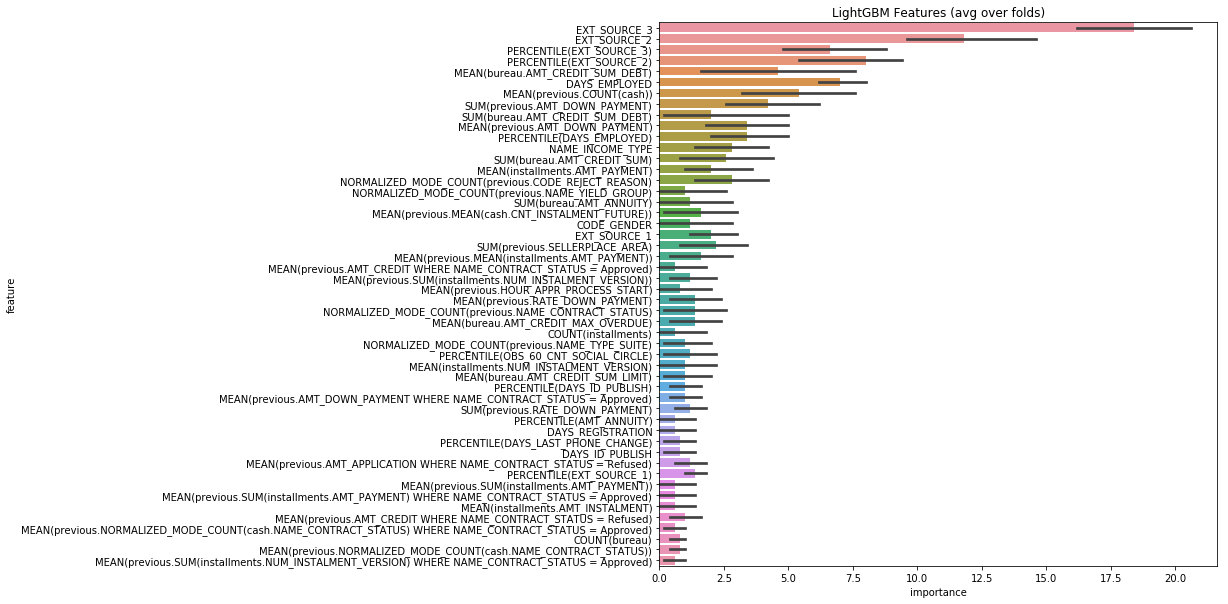

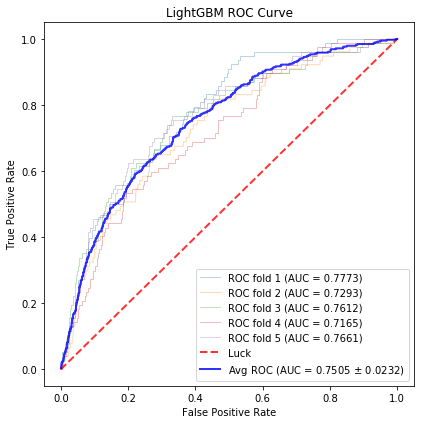

In [50]:
# define validation strategy
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# define baseline model parameters (LightGBM)
train_params = dict(
    boosting_type='gbdt',
    n_estimators=100,
    learning_rate=0.15,
    num_leaves=31,
    colsample_bytree=0.5,
    subsample=1,
    max_depth=8,
    min_split_gain=0.01,
    min_child_weight=100,
    silent=-1,
    verbose=-1,
    random_state=42,
    n_jobs = max(1, cpu_count() // 2),
    max_bin=63,
    categorical_features='auto',
    
    boost_from_average=False, # NEW in 2.1.2, is True by default
    tree_learner='feature',
)

# run cross-validation on a model

y = feature_matrix_train[target_col]
# Train model and get oof and test predictions
oof_preds, test_preds, preds_by_fold, importances = cu.train_model(
    data_=feature_matrix_train,
    test_=feature_matrix_test,
    y_=y,
    folds_=skf, # ORIGIN
    strategy='mean',
    model_params=train_params
)

# Display a few graphs
folds_idx = [(trn_idx, val_idx) for trn_idx, val_idx in skf.split(feature_matrix_train, y)]
cu.display_importances(feature_importance_df_=importances)
cu.display_roc_curve(y_=y, oof_preds_=oof_preds, folds_idx_=folds_idx)

Getting the trained model and the actual submission file with predictions  calculated over WHOLE featuretools dataset over WHOLE data **requires about a day of computations in 32+ GB of RAM**, so use that knowledge on your own risk :)

The good news - the computational structure will remain the same

In [53]:
# save "decorative" submission as .csv file
submission_name = pjoin(
    'submissions', 'submission_baseline_featuretools.csv'
)

test_preds.to_csv(submission_name, encoding='utf-8')

[Back to the Table of Contents](#table-of-contents)

<a id="special-thanks"/>

---
# Special Thanks
---

<img src="./images/will-koehrsen.jpg" height="150" align="right"/>

My Huuuge "Thanks" goes to **William Koehrsen**, great Data Science enthusiast and story-teller, my Kaggle Teammate!

This workshop would not have happened without his participation and inspiration.
<br/>By the way, he recently started working for the [Feature Labs](https://www.featurelabs.com), the inventor of Featuretools :)



I highly recommend checking this awesome guy's activity! 

**Links**:
- [GitHub page](https://github.com/WillKoehrsen)
- [Blog on Medium.com](https://medium.com/@williamkoehrsen)
- [Kaggle profile](https://www.kaggle.com/willkoehrsen)

[Back to the Table of Contents](#table-of-contents)

<a id="useful-links"/>

---
# Useful Links
---
### Featuretools links:
- [Official Site](https://www.featuretools.com/)
- [Documentation](https://docs.featuretools.com/)
- [GitHub](https://github.com/featuretools/featuretools/)
- [StackOverflow issue pages](https://stackoverflow.com/questions/tagged/featuretools)
- Papers regarding approach:
    - [Machine Learning 2.0](https://www.featuretools.com/wp-content/uploads/2018/03/ml20.pdf)
    - [Deep Feature Synthesis](http://www.jmaxkanter.com/static/papers/DSAA_DSM_2015.pdf)

---
### Competition links:
- **Official Sources**:
    - [Home Credit Default Risk (official Kaggle page)](https://www.kaggle.com/c/home-credit-default-risk)
    - [Home Credit (Company Homepage)](http://www.homecredit.net/)
    
    
- **Exploratory Data Analysis (check these awesome kernels for ideas and understanding)**:
    - [Gentle introduction by Will Koehrsen](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction)
    - [Complete EDA and Feature Importance by Lathval](https://www.kaggle.com/codename007/home-credit-complete-eda-feature-importance)
    - [Extensive EDA + Baseline by sban](https://www.kaggle.com/shivamb/homecreditrisk-extensive-eda-baseline-0-772)
    
    
- **Models & Approaches & Misc**:
    - [Good Fun with LightGBM by Olivier](https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm)
    - [CatBoost Starter by Vladimir Demidov](https://www.kaggle.com/yekenot/catboostarter/code)
    - [Tidy XGBoost (warning - R) by Kailex](https://www.kaggle.com/kailex/tidy-xgb-all-tables-0-796)
    - [Genetic Programming Approach by Scirpus](https://www.kaggle.com/scirpus/hybrid-jeepy-and-lgb-ii)

[Back to the Table of Contents](#table-of-contents)